# Prediction and reconstruction for one beat

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append("../")

# This is a no-no in prod code. Use PYTHONPATH variable in shell instead

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.signal import find_peaks

from reconstruct import get_exam_ids_per_file, extract_selected_tracings, reconstruct_traces

# Read file and filter

1. Read a hfd5 file; file number `file_num` from constants.py
2. The whole file may not fit in the laptop memory
3. For now, good filters are:
   * normal_ecg = True
   * abs(age - nn_predicted_age) < 1
4. df = metadata - the `exam_id` is used to read only part of the hfd5 file 
5. trace_file_path - path of the massive hfd5 file to be read. Depends upon the `file_num` variable.

In [4]:
trace_file_path, df = get_exam_ids_per_file()

2025-09-14 12:55:24 INFO     Found 10923 patients in file num 16.


In [5]:
df.head()

,exam_id,age,is_male,nn_predicted_age,1dAVb,RBBB,LBBB,SB,ST,AF,patient_id,death,timey,normal_ecg,trace_file
7057,1683849,35,False,35.244183,False,False,False,False,False,False,1397534,NaN,NaN,True,exams_part16.hdf5
7265,1754825,49,False,49.684593,False,False,False,False,False,False,959059,NaN,NaN,True,exams_part16.hdf5
7281,1689108,41,False,40.222874,False,False,False,False,False,False,1500679,False,1.101369,True,exams_part16.hdf5
7446,1715430,48,False,47.940437,False,False,False,False,False,False,1499416,NaN,NaN,True,exams_part16.hdf5
7448,1796928,41,True,41.678860,False,False,False,False,False,False,673061,False,0.915068,True,exams_part16.hdf5


In [6]:
df.shape

(772, 15)

In [7]:
trace_file_path

'../data/exams_part16.hdf5'

In [8]:
! ls ../data/exams_part16.hdf5

../data/exams_part16.hdf5


# Filter the hfd5 file

1. Read the dataframe, for the `exam_id` column
2. Take in the `trace_file_path`
3. Read that file, but only read the given `exam_id`s from the dataframe
4. If trying to read the whole hfd5 file in Jupyter Notebook - the kerner dies. RIP.

In [9]:
selected_traces = extract_selected_tracings(
    trace_file_path,
    df['exam_id'].values
)

2025-09-13 15:51:29 INFO     reading trace file: ../data/exams_part16.hdf5
2025-09-13 15:51:30 INFO     Found tracings
2025-09-13 15:51:30 INFO     Saved npy file


The np.array `selected_traces` is 3 dimentional -
* axis 0 - patients
* axis 1 - individual ECG channel - 4096 points, about 10 heartbeats data
* axis 2 - number of ECG leads

In [10]:
selected_traces.shape

(772, 4096, 12)

In [11]:
assert(len(df) == len(selected_traces)), "Number of patients should be the same."

# Picking just one patient

In [47]:
trace = selected_traces[1, :, :]
trace.shape

(4096, 12)

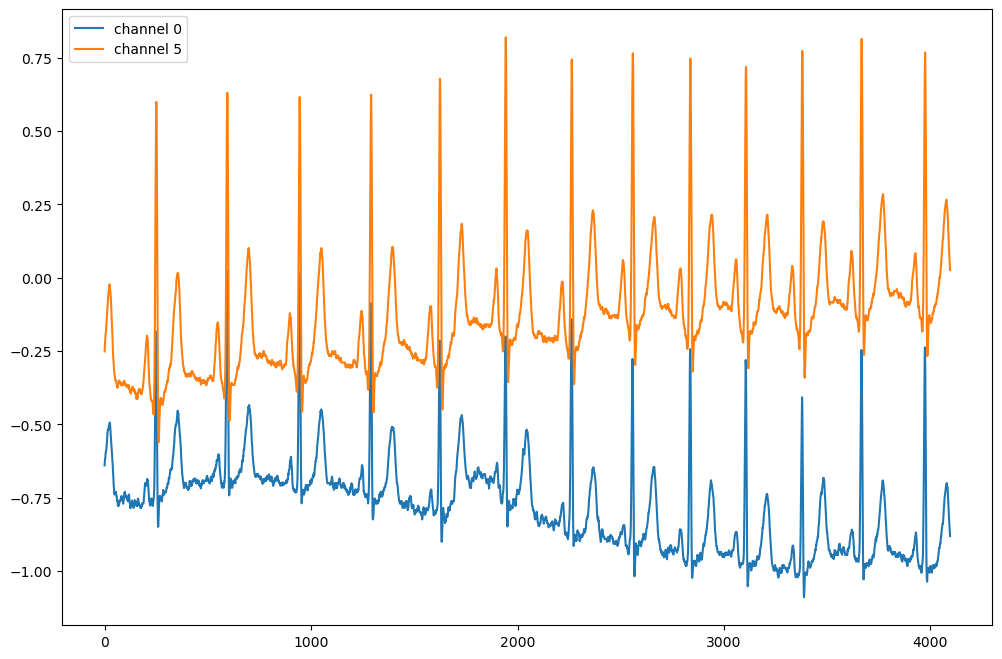

In [48]:
plt.figure(figsize=(12, 8))
i = 0
plt.plot(trace[:, i], label=f"channel {i}")  # first ECG channel
i = 5
plt.plot(trace[:, i], label=f"channel {i}")  # 8th ECG channel
plt.legend()

# ToDo
Find all the normal traces that have the following kind of abnormalities

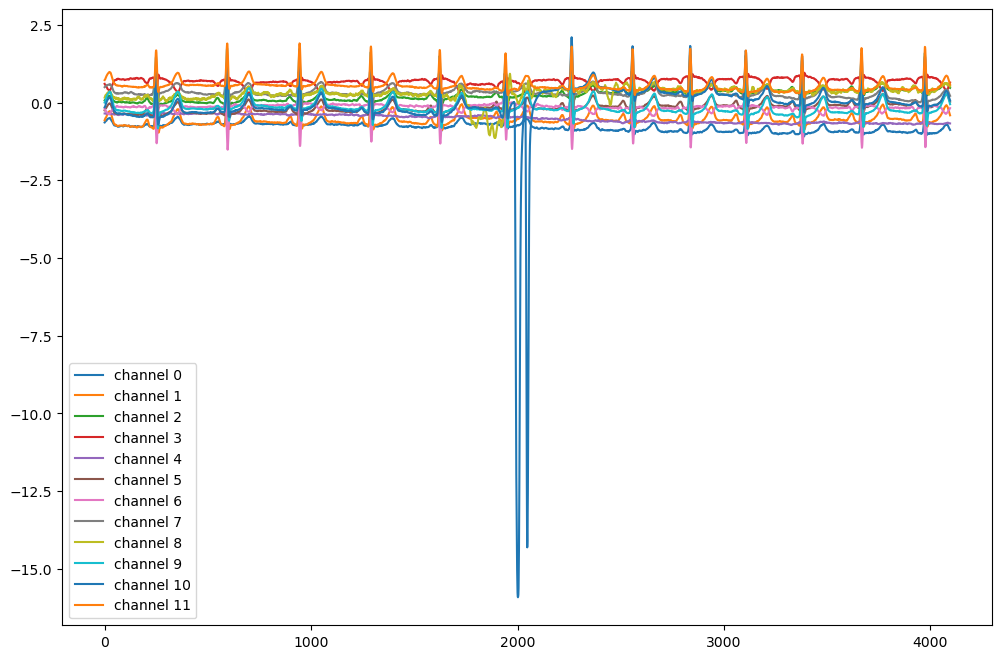

In [50]:
plt.figure(figsize=(12, 8))
for i in range(12):
    plt.plot(trace[:, i], label=f"channel {i}")  # 8th ECG channel
plt.legend()
plt.show()

# channel 10 is odd

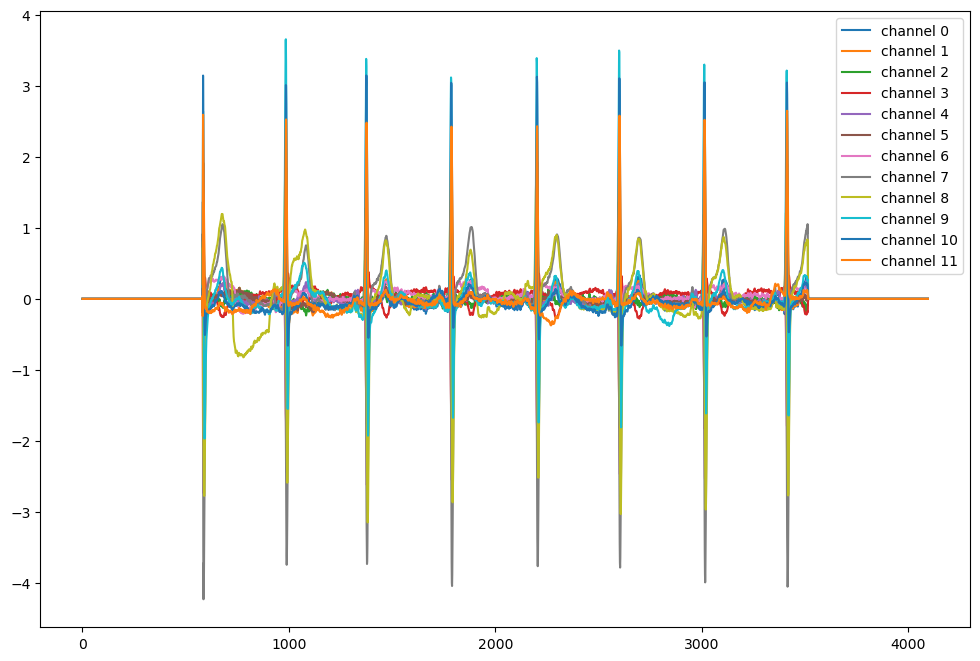

In [53]:
# Using another patient
trace = selected_traces[13, :, :]

# confirm no abnormal data
plt.figure(figsize=(12, 8))
for i in range(12):
    plt.plot(trace[:, i], label=f"channel {i}")  # 8th ECG channel
plt.legend()
plt.show()

# chan 8 is weird

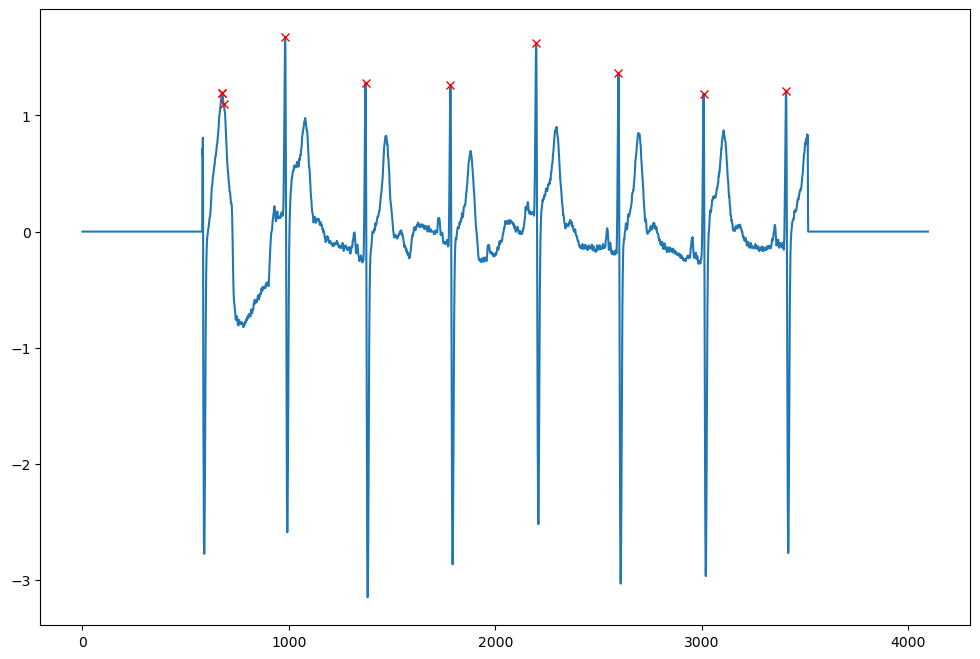

In [54]:
# Using another patient
trace = selected_traces[13, :, :]
trace.shape

chan = 8

trace_plt = trace[:, chan]
trace_mean = np.mean(trace_plt)
height_param = np.quantile(trace_plt, 0.99)
# In 4096 points there should be about 10-11 beats, at most. 
# To find those 10-11 peaks, 0.99 percentile should work

peaks, _ = find_peaks(
    trace_plt,
    height=height_param,
    # prominence= [trace_mean],
)
plt.figure(figsize=(12, 8))
plt.plot(trace_plt)
plt.plot(peaks, trace_plt[peaks], "x", color='r')
plt.show()

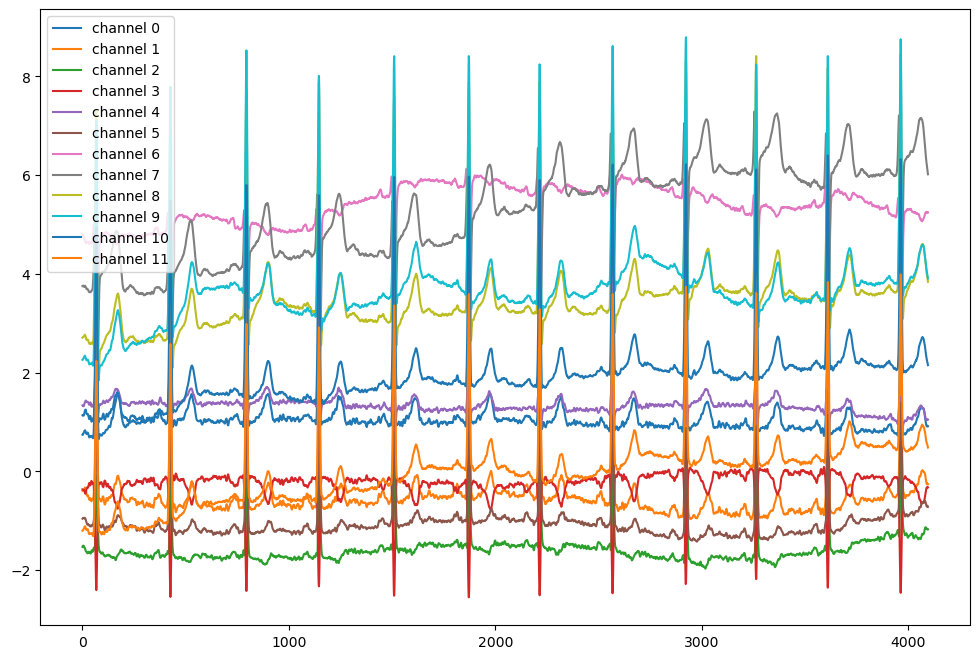

In [63]:
# Using another patient
# patient 0 from this file looks easy to work with
trace = selected_traces[0, :, :]

# confirm no abnormal data
plt.figure(figsize=(12, 8))
for i in range(12):
    plt.plot(trace[:, i], label=f"channel {i}")  # 8th ECG channel
plt.legend()
plt.show()

# chan 8 is weird

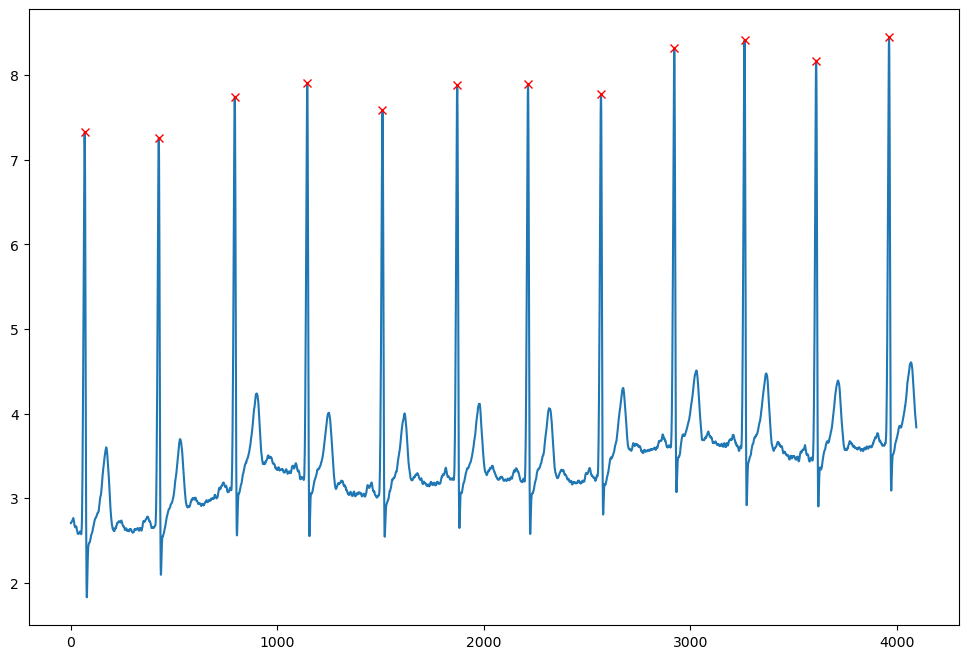

In [62]:
trace = selected_traces[0, :, :]
trace.shape

chan = 8

trace_plt = trace[:, chan]
trace_mean = np.mean(trace_plt)
height_param = np.quantile(trace_plt, 0.95)
# In 4096 points there should be about 10-11 beats, at most. 
# To find those 10-11 peaks, 0.99 percentile should work

peaks, _ = find_peaks(
    trace_plt,
    height=height_param,
    prominence= [trace_mean],
)
plt.figure(figsize=(12, 8))
plt.plot(trace_plt)
plt.plot(peaks, trace_plt[peaks], "x", color='r')
plt.show()

In [64]:
peaks

array([  67,  426,  794, 1145, 1509, 1871, 2214, 2568, 2923, 3263, 3610,
       3963])

# To construct one beat averaged signal

1. Get peaks indices
2. Take the midpoint of the consecutive indices
3. Use one beat as midpoint to midpoint
4. Average those single beats
5. Zero pad the signal to get 4096 points

In [71]:
mid_peaks = []
for i, peak in enumerate(peaks):
    if i < len(peaks) - 1:
        mid_peaks.append(round((peaks[i] + peaks[i + 1]) / 2))
mid_peaks

[246, 610, 970, 1327, 1690, 2042, 2391, 2746, 3093, 3436, 3786]

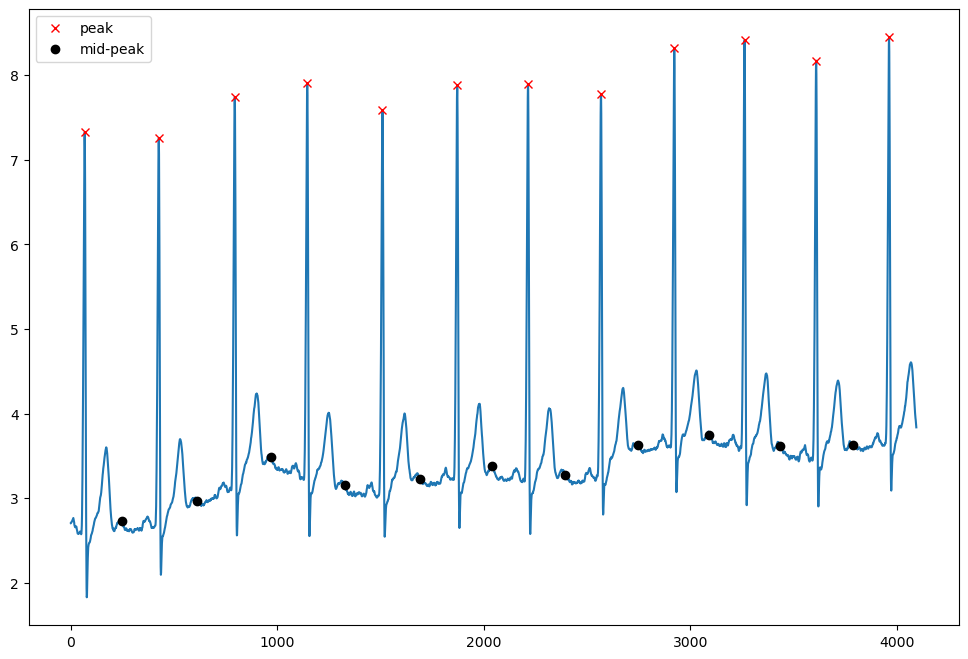

In [76]:
plt.figure(figsize=(12, 8))
plt.plot(trace_plt)
plt.plot(peaks, trace_plt[peaks], "x", color='r', label='peak')
plt.plot(mid_peaks, trace_plt[mid_peaks], "o", color='k', label='mid-peak')
plt.legend()
plt.show()

In [80]:
len(mid_peaks)

11

In [89]:
diff_peak = []
for i, peak in enumerate(peaks):
    if i < len(peaks) - 1:
        print(peaks[i + 1] - peaks[i])
        diff_peak.append(peaks[i + 1] - peaks[i])
int(np.mean(diff_peak))

359
368
351
364
362
343
354
355
340
347
353


354

# The code below is test code. It would still work

In [9]:
x = np.load("../output/p16/p16_age_diff_1_orig.npy")

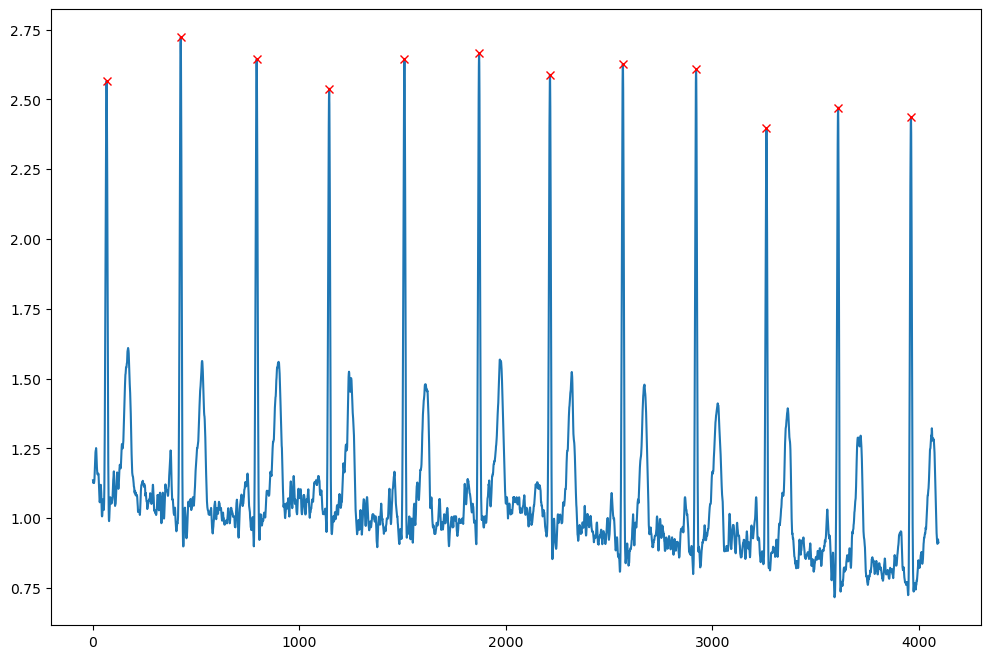

In [10]:
trace = x[0, :, 0]
trace_mean = np.mean(trace)
peaks, _ = find_peaks(
    trace,
    height=0,
    prominence=[trace_mean],
)
plt.figure(figsize=(12, 8))
plt.plot(trace)
plt.plot(peaks, trace[peaks], "x", color='r')
plt.show()

In [16]:
peaks

array([  66,  425,  793, 1144, 1508, 1870, 2213, 2566, 2921, 3262, 3609,
       3962])

In [17]:
zero_padded_trace = np.zeros_like(trace)
zero_padded_trace[peaks[0]: peaks[1]] = trace[peaks[0]: peaks[1]]

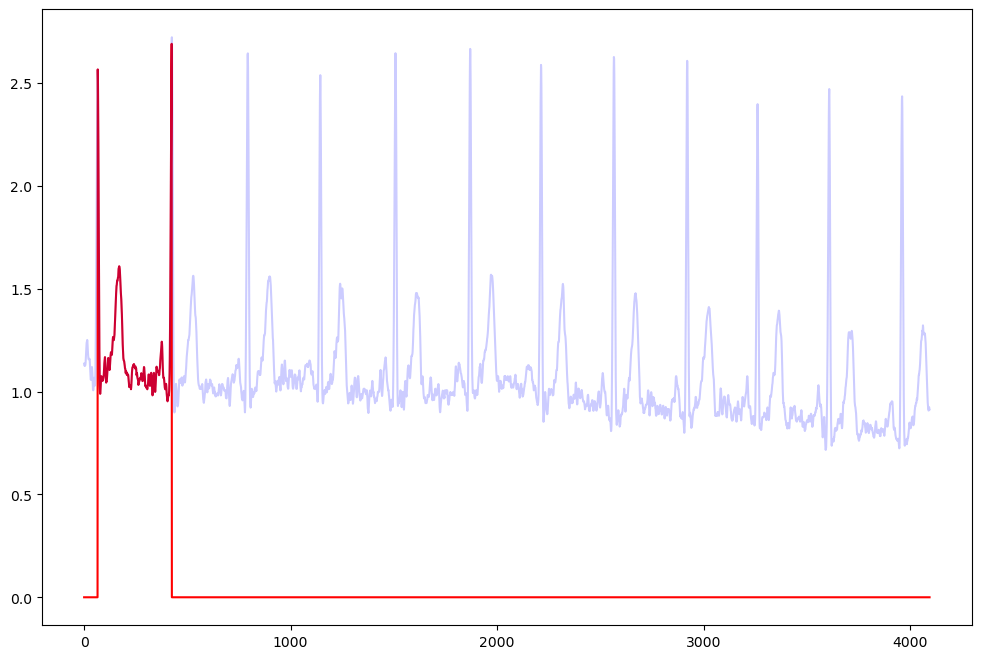

In [18]:
plt.figure(figsize=(12, 8))
plt.plot(zero_padded_trace, color='red')
plt.plot(trace, color='blue', alpha=0.2)

# autorcorr

In [14]:
corr = []
for i in range(4096):
    corr.append(float(pd.Series(trace).autocorr(lag =i)))

/home/sanhita/miniforge3/envs/ecg/lib/python3.13/site-packages/numpy/lib/_function_base_impl.py:3037: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
/home/sanhita/miniforge3/envs/ecg/lib/python3.13/site-packages/numpy/lib/_function_base_impl.py:2894: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
/home/sanhita/miniforge3/envs/ecg/lib/python3.13/site-packages/numpy/lib/_function_base_impl.py:2894: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)


In [15]:
len(corr)

4096

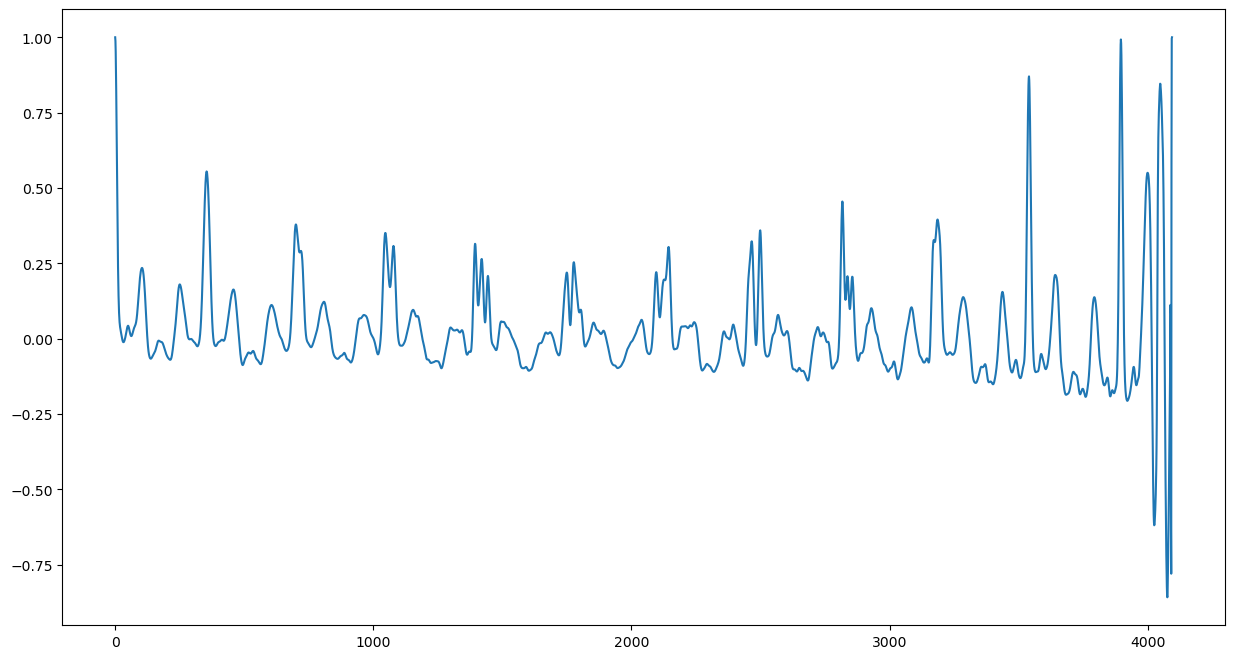

In [17]:
plt.figure(figsize=(15, 8))
plt.plot(corr)

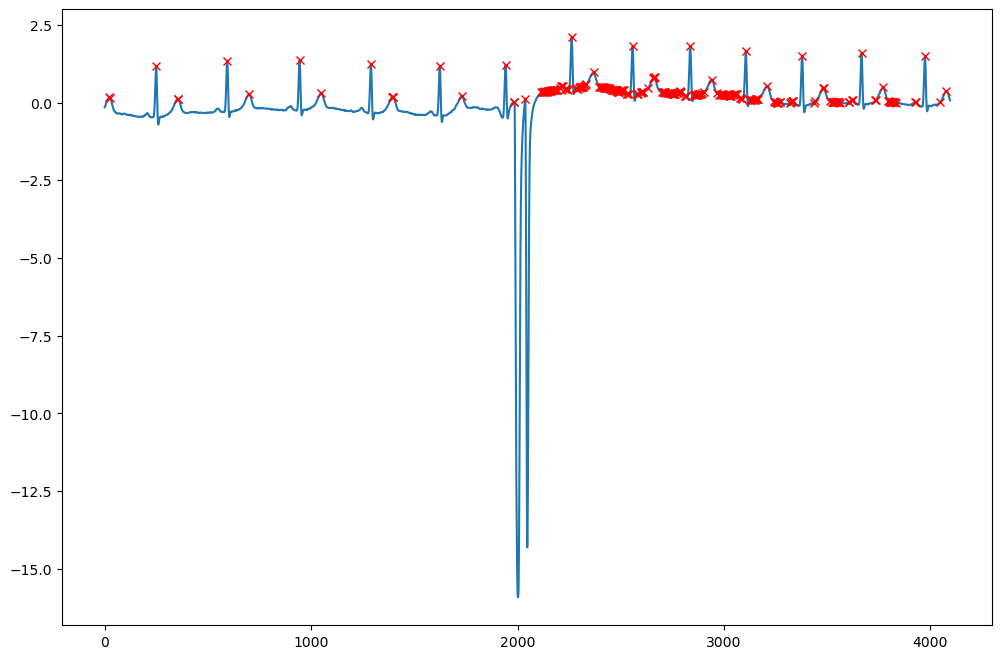

In [18]:
trace = x[1, :, 10]
trace_mean = np.mean(trace)
peaks, _ = find_peaks(
    trace,
    height=0,
    prominence=[trace_mean],
)
plt.figure(figsize=(12, 8))
plt.plot(trace)
plt.plot(peaks, trace[peaks], "x", color='r')
plt.show()

In [19]:
corr = []
for i in range(4096):
    corr.append(float(pd.Series(trace).autocorr(lag=i)))

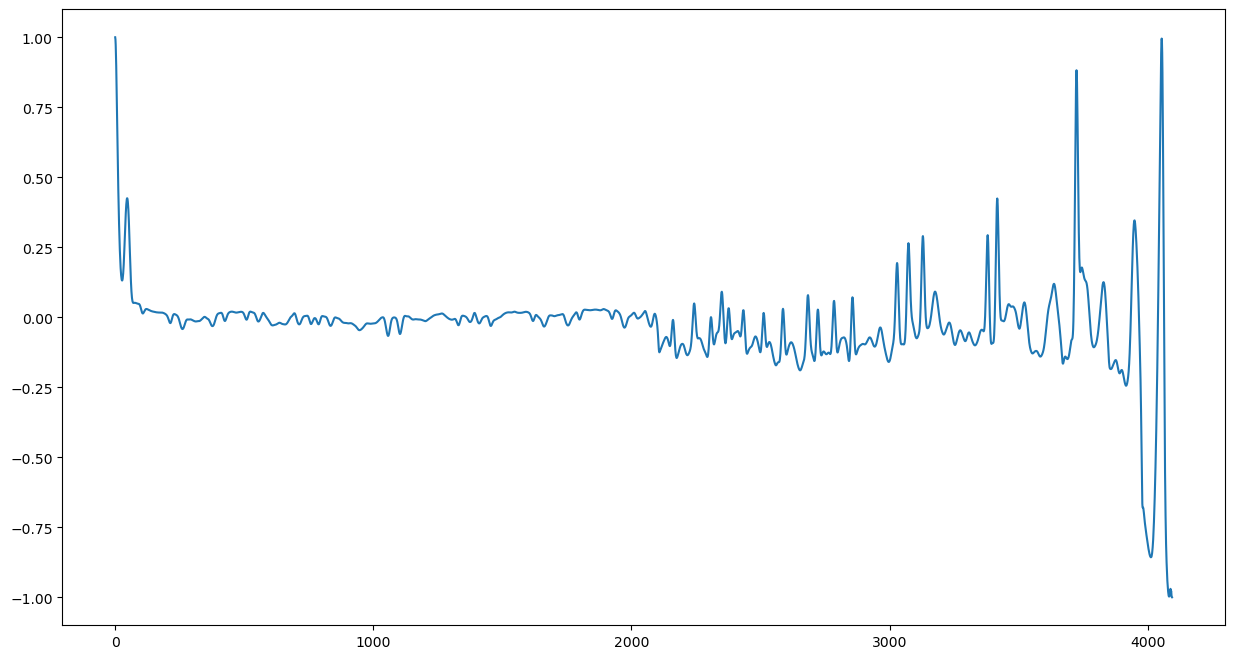

In [20]:
plt.figure(figsize=(15, 8))
plt.plot(corr)

In [21]:
from scipy.signal import correlate

In [26]:
trace_chunk = trace[:750]

In [40]:
corr = []
in2 = trace_chunk
# for i in range(4096):
corr = correlate(trace, trace_chunk, mode='valid')


In [41]:
len(corr)

3347

In [38]:
len(corr[0])

3347

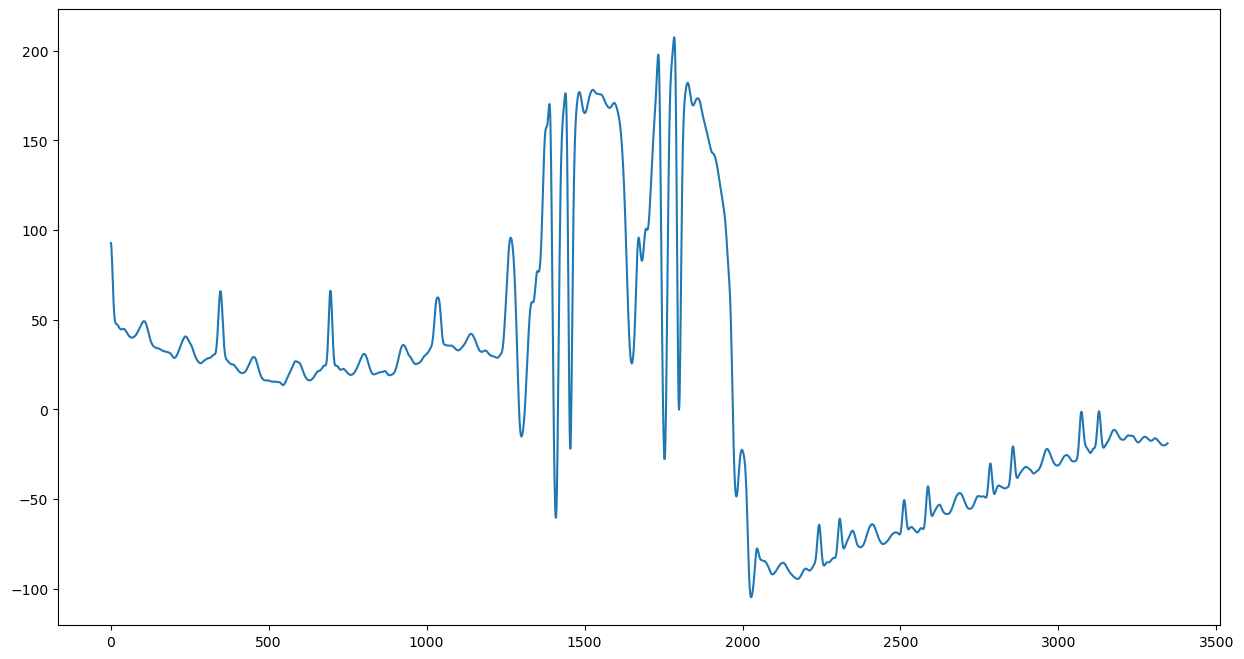

In [42]:
plt.figure(figsize=(15, 8))
plt.plot(corr)

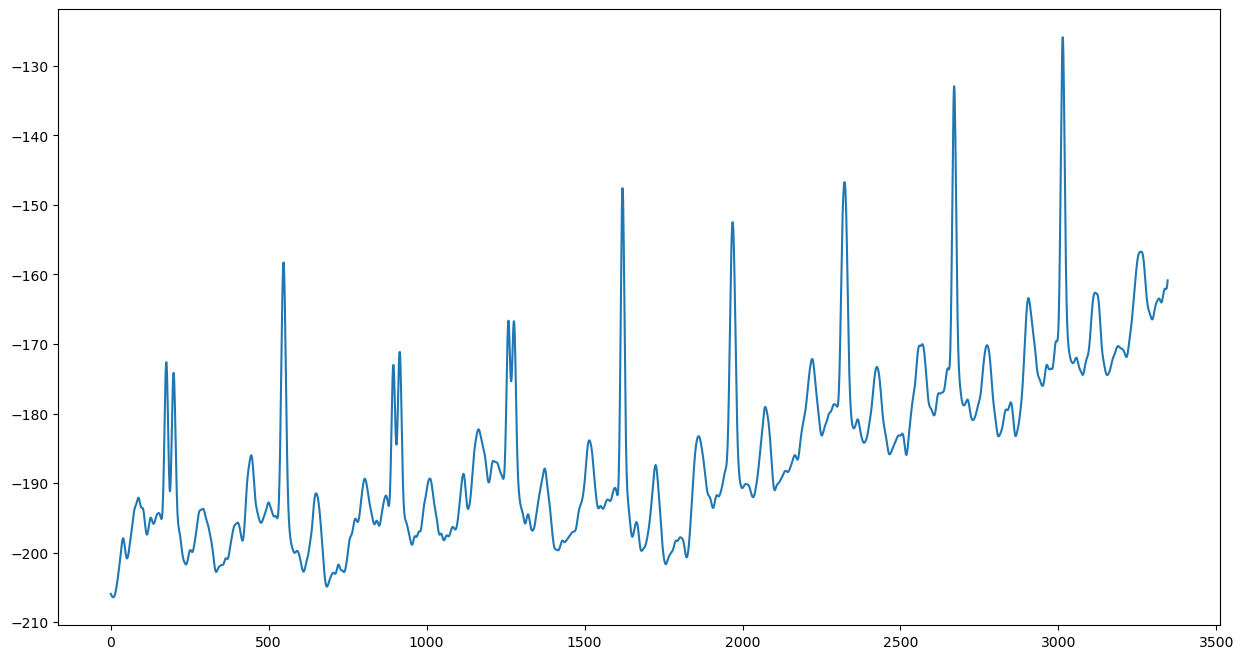

In [45]:
trace = x[0, :, 0]
corr = correlate(trace, trace_chunk, mode='valid', method='direct')
plt.figure(figsize=(15, 8))
plt.plot(corr)